In [34]:
from models.mc import MonteCarloBase, hybridMonteCarlo
import models.benchmarks as bm
from models.longstaff import LSMC_Numpy, LSMC_OpenCL
from models.pso import PSO_Numpy, PSO_OpenCL_hybrid, PSO_OpenCL_scalar, PSO_OpenCL_scalar_oneKnl, PSO_OpenCL_vec
from models.utils import checkOpenCL

import numpy as np
import matplotlib.pyplot as plt

In [35]:
checkOpenCL()


OpenCL Platforms and Devices
Platform - Name: Apple
Platform - Vendor: Apple
Platform - Version: OpenCL 1.2 (Mar  7 2025 21:04:06)
Platform - Profile: FULL_PROFILE
 --------------------------------------------------------
 Device - Name: Apple M1
 Device - Type: ALL | GPU
 Device - Max Clock Speed: 1000 Mhz
 Device - Compute Units: 8
 Device - Global Memory: 5 GB
 Device - Constant Memory: 1 GB
 Device - Local Memory: 32 KB (LOCAL)
 Device - Max Buffer/Image Size: 1 GB
 Device - Max Work Group Size: 256
 Device - Float Atomics Supported: True




In [36]:
S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 20000, 200, 105.0, 'P', 500
# S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish = 100.0, 0.03, 0.3, 1.0, 2**14, 2**8, 110.0, 'P', 2**8
mc = hybridMonteCarlo(S0, r, sigma, T, nPath, nPeriod, K, opttype, nFish)
print(f'{nPath} paths, {nPeriod} periods, {nFish} particles.\n')
print(f'St in shape {mc.St.shape}')

20000 paths, 200 periods, 500 particles.

St in shape (20000, 200)


In [37]:
# St_full = np.concatenate( (np.full(shape=(nPath, 1), fill_value=S0), mcBase.St) , axis=1)
# St_full
# plt.plot(St_full.T, color="b", lw=.7, alpha=.7)
# plt.show()

In [ ]:
prices = []
elapses = []
labels = []

In [39]:
# benchmarks
_, _ = bm.blackScholes(S0, K, r, sigma, T, opttype)
_, _ = bm.binomialEuroOption(S0, K, r, sigma, nPeriod, T, opttype)
_, _ = mc.getEuroOption_np()
_, _ = mc.getEuroOption_cl_optimized()
_, _ = bm.binomialAmericanOption(S0, K, r, sigma, nPeriod, T, opttype)

Black-Scholes price: 13.0084354789132 - 2.15258399839513 ms
Binomial European price: 13.008147982388452 - 15.035999997053295 ms
MonteCarlo Numpy European price: 13.0635390625 - 4.820667003514245 ms
MonteCarlo OpenCL_GPU European price: 13.0635390625 - 53.559791995212436 ms
Binomial American price: 13.397157300671937 - 1.9789170037256554 ms


In [40]:
lsmc_np = LSMC_Numpy(mc, inverseType='benchmark_pinv')
p_lsmc_np, t_lsmc_np = lsmc_np.longstaff_schwartz_itm_path_fast()

lsmc_cl = LSMC_OpenCL(mc, preCalc="optimized")   
# lsmc_cl = LSMC_OpenCL(mc, inverseType='GJ')     
# lsmc_cl = LSMC_OpenCL(mc, inverseType='CA')     
p_lsmc_cl, t_lsmc_cl = lsmc_cl.longstaff_schwartz_itm_path_fast_hybrid()

Longstaff numpy price: 13.344649714907948 - 1408.360540997819 ms
Longstaff OpenCL_GPU price: 13.344868432097908 - 329.69133398728445 ms


In [ ]:
prices.append(p_lsmc_np), prices.append(p_lsmc_cl)
elapses.append(t_lsmc_np), elapses.append(t_lsmc_cl)
labels.append('lsmc_np'), labels.append('lsmc_cl')

(None, None)

In [53]:
pso_search, pso_fit, pso_update = [], [], []

In [54]:
pso_np = PSO_Numpy(mc, nFish)
p_pso_np, t_pso_np, search, fit, rest = pso_np.solvePsoAmerOption_np()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
# print(np.array(search).sum() + np.array(fit).sum() + np.array(rest).sum())
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())


Pso numpy price: 13.407179832458496 - 13358.493667008588 ms
iter: 8, avg component time: search - 0.8040312532102689 ms, fit - 1668.6455730014131 ms, rest - 0.34627087370608933 ms


(None, None, None)

In [55]:
pso_cl_hy = PSO_OpenCL_hybrid(mc, nFish)
p_pso_cl_hy, t_pso_cl_hy, search, fit, rest = pso_cl_hy.solvePsoAmerOption_cl()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())

pso_cl_sc = PSO_OpenCL_scalar(mc, nFish)
p_pso_cl_sc, t_pso_cl_sc, search, fit, rest = pso_cl_sc.solvePsoAmerOption_cl()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())

pso_cl_vec = PSO_OpenCL_vec(mc, nFish)
p_pso_cl_vec, t_pso_cl_vec, search, fit, rest = pso_cl_vec.solvePsoAmerOption_cl()
print(f'iter: {len(search)}, avg component time: search - {np.array(search).mean()} ms, fit - {np.array(fit).mean()} ms, rest - {np.array(rest).mean()} ms')
pso_search.append(np.array(search).mean()), pso_fit.append(np.array(fit).mean()), pso_update.append(np.array(rest).mean())


Pso cl_hybrid price: 13.407176971435547 - 3550.4493749904213 ms
iter: 8, avg component time: search - 8.412989371208823 ms, fit - 432.34235949603317 ms, rest - 3.016223996382905 ms
Pso cl_scalar price: 13.407176971435547 - 1040.0829999998678 ms
iter: 8, avg component time: search - 2.263692496853764 ms, fit - 126.30471874581417 ms, rest - 1.4335625019157305 ms
Pso cl_vec(float16) price: 13.407176971435547 - 647.5640419957926 ms
iter: 8, avg component time: search - 2.355557124246843 ms, fit - 77.10163524825475 ms, rest - 1.4788698754273355 ms


(None, None, None)

In [ ]:
prices.append(p_pso_np), prices.append(p_pso_cl_hy), prices.append(p_pso_cl_sc), prices.append(p_pso_cl_vec)
elapses.append(t_pso_np), elapses.append(t_pso_cl_hy), elapses.append(t_pso_cl_sc), elapses.append(t_pso_cl_vec)
labels.append('pso_np'), labels.append('pso_cl_hybrid'), labels.append('pso_cl_scalar'), labels.append('pso_cl_vector')

(None, None, None, None)

In [50]:
# clear up memory
mc.cleanUp()

### View results

In [56]:
prices, elapses, labels, pso_search, pso_fit, pso_update

([13.344649714907948,
  13.344868432097908,
  13.40718,
  13.407177,
  13.407177,
  13.407177],
 [1408.360540997819,
  329.69133398728445,
  14924.445374999777,
  3552.4843750026776,
  1005.9889580006711,
  644.1532080061734],
 ['lsmc_np',
  'lsmc_cl',
  'pso_np',
  'pso_cl_hybrid',
  'pso_cl_scalar',
  'pso_cl_vector'],
 [0.8040312532102689, 8.412989371208823, 2.263692496853764, 2.355557124246843],
 [1668.6455730014131,
  432.34235949603317,
  126.30471874581417,
  77.10163524825475],
 [0.34627087370608933,
  3.016223996382905,
  1.4335625019157305,
  1.4788698754273355])

Black-Scholes price: 13.0084354789132 - 1.219124998897314 ms
Binomial American price: 13.397157300671937 - 5.573040994931944 ms


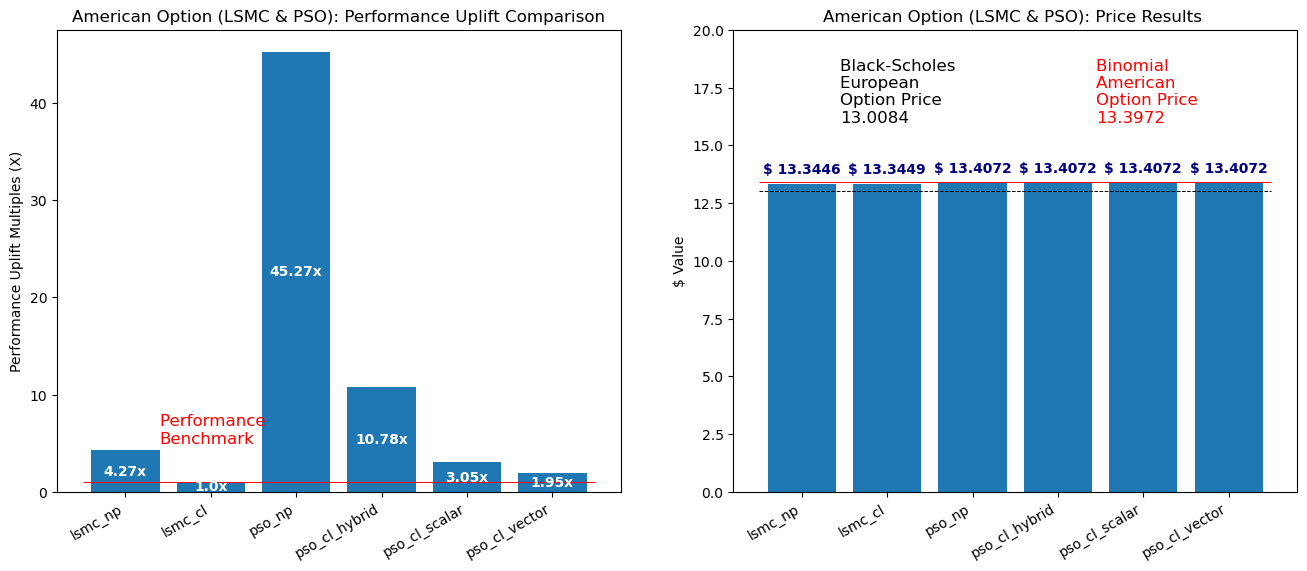

In [129]:
blackscholes, _ = bm.blackScholes(S0, K, r, sigma, T, opttype)
binomial, _ = bm.binomialAmericanOption(S0, K, r, sigma, nPeriod, T, opttype)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

elapses = np.array(elapses)
uplift = list(np.round(elapses / np.min(elapses), 2))

bar1 = ax1.bar(np.arange(len(prices)), uplift)
ax1.set_title('American Option (LSMC & PSO): Performance Uplift Comparison')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(prices)), labels=labels, rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
ax1.hlines(1, -.5, 5.5, colors='r', lw=.7) 
ax1.text(0.4, 5, 'Performance \nBenchmark', color = 'red', fontsize=12)

bar2 = ax2.bar(np.arange(len(prices)), prices)
ax2.set_title('American Option (LSMC & PSO): Price Results ')
ax2.set_ylabel('$ Value')
ax2.set_xticks(np.arange(len(prices)), labels=labels, rotation=30, horizontalalignment='right')
ax2.set_ylim(ymax=20)
ax2.bar_label(bar2, fmt='$ %.4f', label_type='edge', rotation=0, color='navy', fontsize = 10, padding=5, fontweight = 'bold')
ax2.hlines(blackscholes, -.5, 5.5, colors='black', lw=.7, linestyles='dashed') 
ax2.hlines(binomial, -.5, 5.5, colors='r', lw=.7) 
ax2.text(.45, 16., f'Black-Scholes \nEuropean \nOption Price \n{np.round(blackscholes,4)}', color = 'black', fontsize=12)
ax2.text(3.45, 16., f'Binomial \nAmerican \nOption Price \n{np.round(binomial,4)}', color = 'red', fontsize=12)

plt.show()

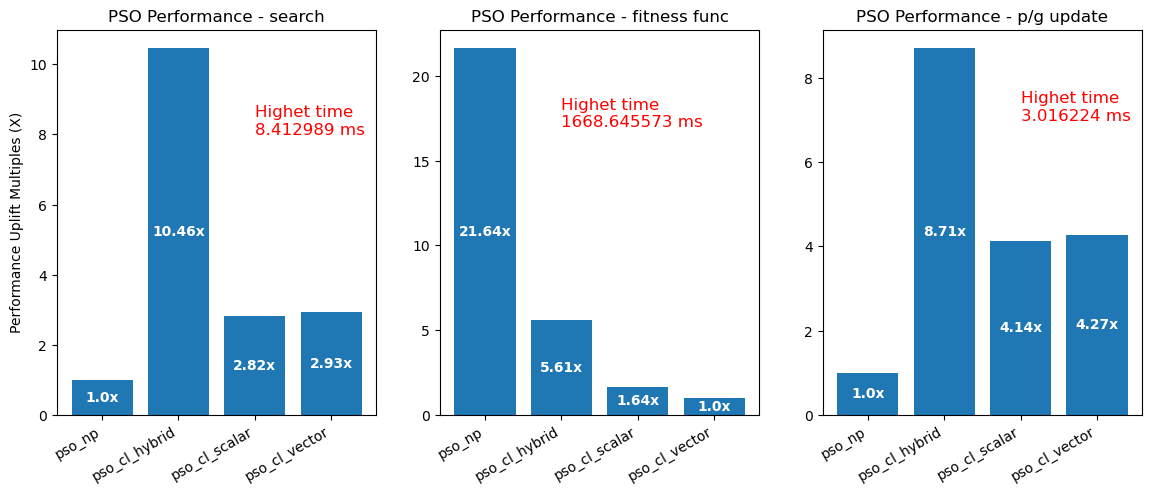

In [119]:
def multiple(a_list):
    arr = np.array(a_list)
    return list(np.round(arr / np.min(arr), 2))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,5))
pso_labels = labels[2:]

bar1 = ax1.bar(np.arange(len(pso_search)), multiple(pso_search))
ax1.set_title('PSO Performance - search')
ax1.set_ylabel('Performance Uplift Multiples (X)')
ax1.set_xticks(np.arange(len(pso_search)), labels=pso_labels, rotation=30, horizontalalignment='right')
ax1.bar_label(bar1, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
ax1.text(2, 8., f'Highet time \n{np.round(np.array(pso_search).max(),6)} ms', color = 'red', fontsize=12)

bar2 = ax2.bar(np.arange(len(pso_fit)), multiple(pso_fit))
ax2.set_title('PSO Performance - fitness func')
ax2.set_xticks(np.arange(len(pso_fit)), labels=pso_labels, rotation=30, horizontalalignment='right')
ax2.bar_label(bar2, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
ax2.text(1, 17., f'Highet time \n{np.round(np.array(pso_fit).max(),6)} ms', color = 'red', fontsize=12)

bar3 = ax3.bar(np.arange(len(pso_update)), multiple(pso_update))
ax3.set_title('PSO Performance - p/g update')
ax3.set_xticks(np.arange(len(pso_update)), labels=pso_labels, rotation=30, horizontalalignment='right')
ax3.bar_label(bar3, fmt='{}x', label_type='center', color='white', fontsize = 10, fontweight = 'bold')
ax3.text(2, 7., f'Highet time \n{np.round(np.array(pso_update).max(),6)} ms', color = 'red', fontsize=12)


plt.show()